In [1]:
DATA_PATH="./data"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
part_6 = pd.read_json(f"{DATA_PATH}/imdb/part-06.json", orient="records")
part_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499997 entries, 0 to 499996
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   review_id       499997 non-null  object 
 1   reviewer        499997 non-null  object 
 2   movie           499997 non-null  object 
 3   rating          303683 non-null  float64
 4   review_summary  499997 non-null  object 
 5   review_date     499997 non-null  object 
 6   spoiler_tag     499997 non-null  int64  
 7   review_detail   499997 non-null  object 
 8   helpful         499997 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 34.3+ MB


In [5]:
part_6.head()

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,rw0099142,ed.wenn,Le Samouraï (1967),9.0,Cooler Than Cool,26 November 2000,0,Surely one of the suavest movies ever made. Cr...,"[8, 21]"
1,rw0099143,the red duchess,Le Samouraï (1967),10.0,"Along with 'The Wizard of Oz', the supreme fil...",7 December 2000,1,"To see how beautiful, moving, exciting and ast...","[219, 284]"
2,rw0099144,esteban1747,Le Samouraï (1967),7.0,"Jeff Costello, a nearly perfect gangster",20 September 2001,0,A rare film where Alain Delon played together ...,"[2, 12]"
3,rw0099146,youroldpaljim,Le Samouraï (1967),NaN,Paris envy?,24 April 2002,0,First let me say that I think LE SAMOURAI is a...,"[4, 14]"
4,rw0099147,tasgal,Le Samouraï (1967),5.0,Stylish and cluelessly silly. Inoffensive.,11 January 2003,1,The movie's title and opening epigraph refer t...,"[13, 32]"


In [6]:
part_6 = part_6.loc[:, ['review_id', 'review_detail', 'spoiler_tag']]

In [7]:
part_6

,review_id,review_detail,spoiler_tag
0,rw0099142,Surely one of the suavest movies ever made. Cr...,0
1,rw0099143,"To see how beautiful, moving, exciting and ast...",1
2,rw0099144,A rare film where Alain Delon played together ...,0
3,rw0099146,First let me say that I think LE SAMOURAI is a...,0
4,rw0099147,The movie's title and opening epigraph refer t...,1
...,...,...,...
499992,rw0099137,"Actually, the first three or four times I saw ...",0
499993,rw0099138,This movie glorifies the worst stereotypes of ...,0
499994,rw0099139,"38. LE SAMOURAI (French-action, 1967) Jef (Ala...",0
499995,rw0099140,"I found ""Le Samourai"" (**) to be more about st...",0


In [8]:
del part_6

In [9]:
USE_FULL_IMDB = True

In [10]:
file_list = [f"{DATA_PATH}/imdb/part-0{x}.json" for x in range(1, 7)] if USE_FULL_IMDB else [f"data/imdb/part-06.json"]
dfs = []

for file in tqdm(file_list):
    data = pd.read_json(file, orient="records", dtype={"spoiler_tag": 'category'}).loc[:, ["review_detail", "spoiler_tag"]].rename(columns={"review_detail":"text", "spoiler_tag": "label"})
    dfs.append(data)

imdb_df = pd.concat(dfs, copy=False, ignore_index=True)
del dfs

100%|██████████| 6/6 [02:21<00:00, 23.66s/it]


In [11]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571499 entries, 0 to 5571498
Data columns (total 2 columns):
 #   Column  Dtype   
---  ------  -----   
 0   text    object  
 1   label   category
dtypes: category(1), object(1)
memory usage: 47.8+ MB


In [12]:
imdb_df.head()

,text,label
0,"I enjoyed the first season, but I must say I t...",0
1,I know Iceland is a small country and police d...,0
2,"Except K K , no other actor looks comfortable ...",0
3,I'm guessing that as a 62 year old white woman...,0
4,Here's the truth. There's not much to this mov...,0


# EDA

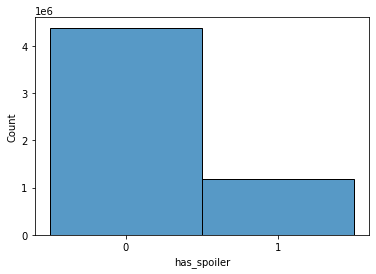

In [13]:
ax = sns.histplot(imdb_df["label"].astype('str'));
ax.set_xlabel("has_spoiler")
plt.savefig("imdb_classes.jpg")
plt.show()

In [14]:
neg = imdb_df.loc[imdb_df.label == 0, ].shape[0]
print(neg)

4384888


In [15]:
pos = imdb_df.loc[imdb_df.label == 1, ].shape[0]
print(pos)

1186611


In [16]:
import re
par  = "This is a paragraph? So it is! Ok, there are 3 sentences."
re.split(r'[.!?]+', par)

['This is a paragraph', ' So it is', ' Ok, there are 3 sentences', '']

In [17]:
sentence_counts = [len([y for y in x.split('.') if y]) for x in tqdm(imdb_df['text'])]

100%|██████████| 5571499/5571499 [00:13<00:00, 409804.94it/s]


<AxesSubplot:ylabel='Count'>

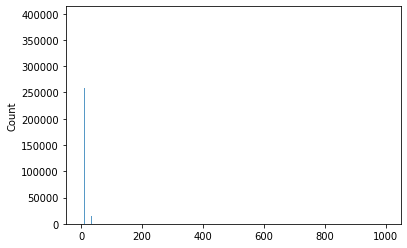

In [18]:
sns.histplot(sentence_counts)

In [19]:
len([x for x in sentence_counts if x > 200])

32

In [20]:
len([x for x in sentence_counts if x > 100])

625

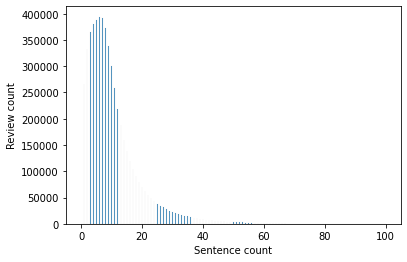

In [21]:
ax = sns.histplot([x for x in sentence_counts if x <= 100])
ax.set_xlabel('Sentence count')
ax.set_ylabel('Review count')
plt.savefig('imdb-sentence-length-hist.jpg')
plt.show()

In [22]:
np.random.seed(0)
indices_to_delete = np.random.choice(imdb_df.loc[imdb_df.label == 0, ].index, size=neg - pos, replace=False)

In [23]:
imdb_df = imdb_df.drop(indices_to_delete)

In [24]:
imdb_df.loc[imdb_df.label == 0, ].shape[0], imdb_df.loc[imdb_df.label == 1, ].shape[0]

(1186611, 1186611)

In [25]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [26]:
def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)

In [27]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [28]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(model_name, classifier_dropout=0.1)

2022-11-29 23:06:36.796310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 23:06:37.519597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38419 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-11-29 23:06:39.324043: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: [

In [29]:
from datasets import Dataset

In [30]:
imdb_as_list = imdb_df.to_dict('records')

In [31]:
imdb_as_list[0]

{'text': "I'm guessing that as a 62 year old white woman I'm not the target demographic but I enjoyed this show. Good to see others perspectives and loved the wry humor. More entertaining than The Office and Parks & Rec. It does make broad negative assumptions about all whites though",
 'label': 0}

In [32]:
del imdb_df

In [33]:
tokenized_imdb = Dataset.from_list(imdb_as_list).map(preprocess_function, batched=True)

  0%|          | 0/2374 [00:00<?, ?ba/s]

In [34]:
tokenized_imdb

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2373222
})

In [35]:
train_testvalid = tokenized_imdb.train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

In [36]:
def create_tf_dataset(tokenized_dataset):
    return model.prepare_tf_dataset(
        tokenized_dataset, shuffle=True, batch_size=32, collate_fn=data_collator
    )

In [37]:
tf_imdb_train = create_tf_dataset(train_testvalid["train"])
tf_imdb_valid = create_tf_dataset(test_valid["train"])
tf_imdb_test = create_tf_dataset(test_valid["test"])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [38]:
from transformers import create_optimizer

batch_size = 32

num_epochs = 3

batches_per_epoch = len(train_testvalid["train"]) // batch_size

total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, 
    num_train_steps=total_train_steps)

In [39]:
print(batches_per_epoch)

59330


In [40]:
class BalancedSparseCategoricalAccuracy(tf.keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name='balanced_sparse_categorical_accuracy', dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)

In [41]:
model.compile(optimizer=optimizer,
             metrics=['accuracy', BalancedSparseCategoricalAccuracy()])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [42]:
csv_logger = tf.keras.callbacks.CSVLogger('imdb_fit_log.csv', append=True, separator=';')

In [43]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./checkpoints/best_val_imdb",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# model.fit(x=tf_imdb_train, validation_data=tf_imdb_valid, epochs=2, callbacks=[model_checkpoint_callback, csv_logger])

Epoch 1/2
 6102/59330 [==>...........................] - ETA: 6:44:04 - loss: 0.5269 - accuracy: 0.7304 - balanced_sparse_categorical_accuracy: 0.7301

In [51]:
model.load_weights('./checkpoints/best_val_imdb')

In [48]:
model.evaluate(tf_imdb_valid)

7416/7416 [==============================] - 1167s 157ms/step - loss: 0.4605 - accuracy: 0.7782 - balanced_sparse_categorical_accuracy: 0.7783


[0.4604688584804535, 0.7782076001167297, 0.7783032059669495]

In [52]:
model.evaluate(tf_imdb_test)

7416/7416 [==============================] - 1161s 156ms/step - loss: 0.4615 - accuracy: 0.7770 - balanced_sparse_categorical_accuracy: 0.7772


[0.46146705746650696, 0.7770318984985352, 0.7771524786949158]

In [53]:
auc = tf.keras.metrics.AUC()
acc = tf.keras.metrics.Accuracy()

fp = tf.keras.metrics.FalsePositives()
fn = tf.keras.metrics.FalseNegatives()
tp = tf.keras.metrics.TruePositives()
tn = tf.keras.metrics.TrueNegatives()

for batch_data, batch_labels in tqdm(tf_imdb_test):
    preds = tf.nn.softmax(model(batch_data)[0])[:,1]
    auc.update_state(batch_labels, preds)
    acc.update_state(batch_labels, preds>=0.5)
    
    fp.update_state(batch_labels, preds >= 0.5)
    fn.update_state(batch_labels, preds >= 0.5)
    tp.update_state(batch_labels, preds >= 0.5)
    tn.update_state(batch_labels, preds >= 0.5)

100%|██████████| 7416/7416 [18:42<00:00,  6.61it/s]


In [54]:
print("IMDB Test")
print(f"AUC={auc.result().numpy()}")
print(f"ACC={acc.result().numpy()}")
print(f"FP={fp.result().numpy()}")
print(f"FN={fn.result().numpy()}")
print(f"TP={tp.result().numpy()}")
print(f"TN={tn.result().numpy()}")

IMDB Test
AUC=0.8653112053871155
ACC=0.777061402797699
FP=20397.0
FN=32509.0
TP=86214.0
TN=98192.0
